In [1]:
!pip install split-folders
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

import zipfile,os
import splitfolders
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras
import shutil


In [2]:
import pathlib

## Download Rice leaf Disease Dataset from Kaggle

In [3]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [4]:
! kaggle datasets download badhon7432/paddyleafdiseaseuci

 95% 153M/161M [00:01<00:00, 119MB/s]
100% 161M/161M [00:01<00:00, 118MB/s]


In [5]:
! kaggle datasets download vbookshelf/rice-leaf-diseases

 85% 31.0M/36.7M [00:00<00:00, 62.9MB/s]
100% 36.7M/36.7M [00:00<00:00, 74.3MB/s]


In [6]:
local_zip = '/content/paddyleafdiseaseuci.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
local_zip = '/content/rice-leaf-diseases.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
os.listdir("/content/train")

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [9]:
! ls train/'Brown spot' | head

DSC_0100.jpg
DSC_0101.jpg
DSC_0105.jpg
DSC_0107.jpg
DSC_0108.jpg
DSC_0110.jpg
DSC_0111.jpg
DSC_0113.jpg
DSC_0115.jpg
DSC_0117.jpg


In [10]:
#Blok menggabungkan 2 dataset
#Coba bandingkan tidak jalankan blok ini, dan dengan menjalankan blok ini
root_dir = '/content/rice_leaf_diseases' # data root path
classes_dir = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut'] #total labels

val_ratio = 0.1
test_ratio = 0.1

total_data = 0
total_train_data = 0 
total_validation_data = 0
total_test_data = 0
for cls in classes_dir:
  # Creating partitions of the data after shuffeling
    src = root_dir + '/' + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    print(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                              int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, '/content/train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, '/content/valid/' + cls)

    for name in test_FileNames:
        shutil.copy(name, '/content/test/' + cls)

    #count total images
    total_data += len(allFileNames)
    total_train_data += len(train_FileNames)
    total_validation_data += len(val_FileNames)
    total_test_data += len(test_FileNames)


print('Total images: ', total_data)
print('Training: ', total_train_data)
print('Validation: ', total_validation_data)
print('Testing: ', total_test_data)

/content/rice_leaf_diseases/Bacterial leaf blight
/content/rice_leaf_diseases/Brown spot
/content/rice_leaf_diseases/Leaf smut
Total images:  120
Training:  96
Validation:  12
Testing:  12


In [11]:
!rm -rf rice_leaf_diseases_train
!rm -rf rice_leaf_diseases_val
!rm -rf rice_leaf_diseases_test

## Augmentasi Gambar

In [12]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.1,
                    #validation_split = 0.4,
                    fill_mode = 'nearest'
                    )

val_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [13]:
train_dir = "/content/train"
validation_dir = "/content/valid"
testing_dir = "/content/test"

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(160, 160),
        color_mode='rgb', 
        batch_size=32,
        class_mode='categorical') 
        
 
validation_generator = val_datagen.flow_from_directory(
        validation_dir, 
        target_size=(160, 160), 
        color_mode='rgb',
        batch_size=32, 
        class_mode='categorical')
        
 
testing_generator = test_datagen.flow_from_directory(
        testing_dir, 
        target_size=(160, 160), 
        color_mode='rgb',
        batch_size=32, 
        class_mode='categorical')

Found 937 images belonging to 3 classes.
Found 230 images belonging to 3 classes.
Found 175 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


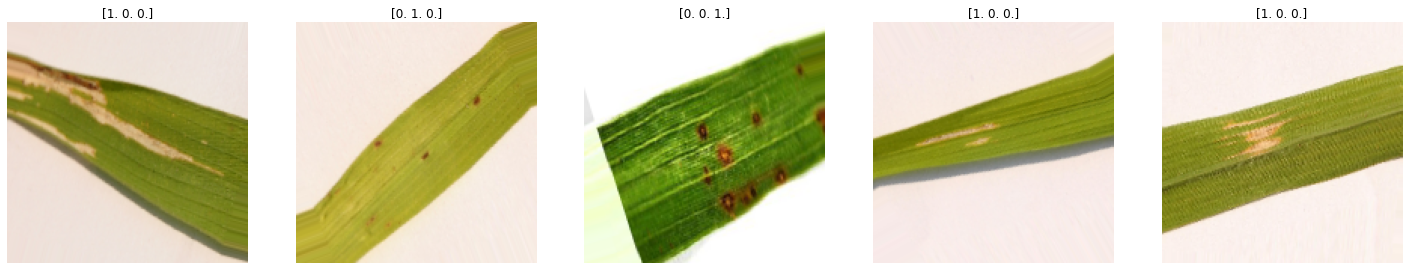

In [14]:
from pathlib import Path
import os
def plotting_images(DataImages,labels):
    row=1
    column=5
    fig, axs = plt.subplots(row, column, figsize=(25,25))
    axs = axs.flatten()
    for images, label, ax in zip(DataImages,labels, axs):
        ax.imshow(images)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

Train_sample, y = next(train_generator)
plotting_images(Train_sample[:5],y[:5])

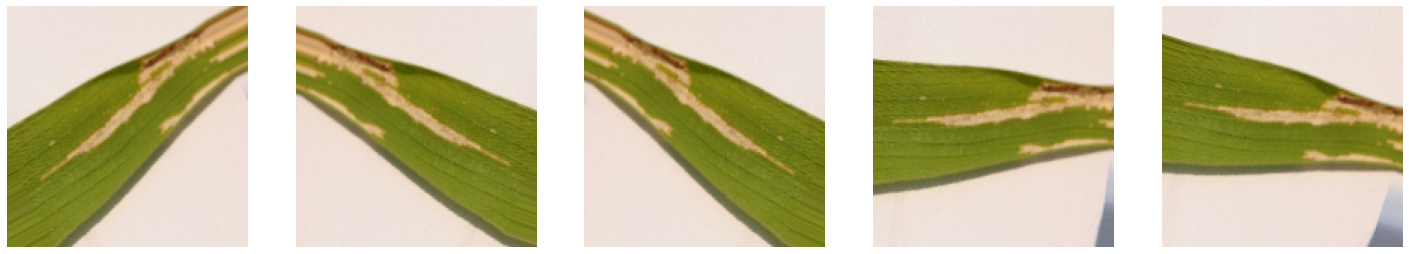

In [15]:
def plotting_au(DataImages):
    fig, axs = plt.subplots(1,5, figsize=(25,25))
    axs = axs.flatten()
    for images, ax in zip(DataImages, axs):
        ax.imshow(images)
        ax.axis('off')
    plt.show()

augmented_result = [train_generator[0][0][0] for i in range(5)]
plotting_au(augmented_result)

# MobileNetV2

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #To ensure that your images are pre-processed as expected for the pre-trained network you are using.

In [18]:
base_model= MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)))
for layer in base_model.layers:
	layer.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [20]:
x = base_model.output
x = global_average_layer(x)
x = tf.keras.layers.Flatten()(x)    
x= tf.keras.layers.Dense(225,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  
prediction=tf.keras.layers.Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## Compile Model

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("Akurasi Diatas 97%")
      self.model.stop_training = True

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,  
      epochs=25,
      validation_data=validation_generator, 
      validation_steps=4,
      callbacks=[CustomCallback()],  
     )

Epoch 1/25
30/30 [==============================] - 51s 2s/step - loss: 1.2855 - accuracy: 0.4760 - val_loss: 0.6761 - val_accuracy: 0.7422
Epoch 2/25
30/30 [==============================] - 46s 2s/step - loss: 0.6452 - accuracy: 0.7321 - val_loss: 0.4471 - val_accuracy: 0.8516
Epoch 3/25
30/30 [==============================] - 46s 2s/step - loss: 0.4702 - accuracy: 0.8100 - val_loss: 0.3512 - val_accuracy: 0.8672
Epoch 4/25
30/30 [==============================] - 46s 2s/step - loss: 0.3661 - accuracy: 0.8655 - val_loss: 0.3196 - val_accuracy: 0.8750
Epoch 5/25
30/30 [==============================] - 46s 2s/step - loss: 0.3082 - accuracy: 0.8890 - val_loss: 0.2932 - val_accuracy: 0.8906
Epoch 6/25
30/30 [==============================] - 47s 2s/step - loss: 0.2535 - accuracy: 0.9146 - val_loss: 0.2963 - val_accuracy: 0.9219
Epoch 7/25
30/30 [==============================] - 48s 2s/step - loss: 0.2247 - accuracy: 0.9221 - val_loss: 0.2995 - val_accuracy: 0.8828
Epoch 8/25
30/30 [==

## Ploting Model

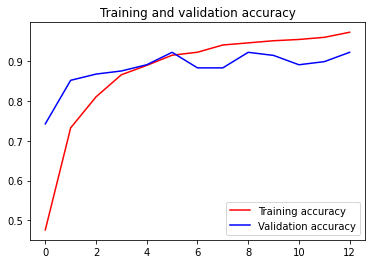

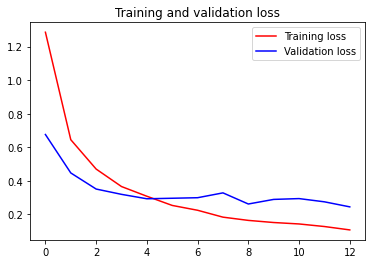

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

## Test Upload

In [25]:
#fungsi untuk mendapatkan label indeks hasil deteksi
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string


Saving 1 (2).jpg to 1 (2).jpg
{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
Leaf smut
Hasil Prediksi: Leaf smut

Bacterial leaf blight:1.03%
Brown spot:1.85%
Leaf smut:97.12%


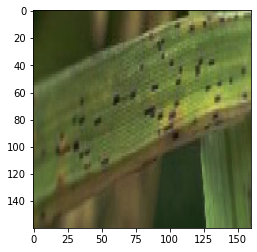

In [26]:
uploaded = files.upload()
lbl=train_generator.class_indices.keys()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  pr=model.predict(images)[0]
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))
  print()
  for(l,p) in zip(lbl,pr):
    print("{}:{:.2f}%".format(l,p*100))

In [29]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
pred = model.predict_generator(testing_generator) 
y_predict = np.argmax(pred, axis=1)
print(y_predict)
print(testing_generator.classes)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1 2 2 2 0 1 0 1 0 2 2 1 1 0 0 2 1 1 0 2 2 0 1 0 1 0 0 1 2 1 2 1 1 0 1 1 1
 1 1 1 0 1 2 1 1 2 1 0 0 1 0 2 0 2 0 2 2 1 2 1 2 2 0 0 0 0 2 2 0 2 1 1 0 0
 0 1 0 2 2 1 0 1 1 0 0 0 1 2 0 2 1 0 2 2 2 2 1 1 1 1 1 0 2 0 1 2 0 2 0 2 2
 2 1 1 2 0 2 0 0 0 0 1 1 2 1 1 1 1 2 2 0 1 0 1 2 0 0 2 2 2 1 0 2 0 2 2 1 1
 2 0 2 1 1 1 1 0 2 0 2 0 0 2 1 2 0 2 2 2 2 0 2 2 1 2 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [30]:
print('Classification Report')
target = ['Bacterial leaf blight','Brown spot','Leaf smut']
print(classification_report(testing_generator.classes, y_predict, target_names=target))

Classification Report
                       precision    recall  f1-score   support

Bacterial leaf blight       0.31      0.29      0.30        59
           Brown spot       0.28      0.30      0.29        57
            Leaf smut       0.39      0.41      0.40        59

             accuracy                           0.33       175
            macro avg       0.33      0.33      0.33       175
         weighted avg       0.33      0.33      0.33       175



##Export the Model

In [ ]:
UseMobileNet_Saved_Model="exp_saved_model"

In [ ]:
tf.saved_model.save(model,UseMobileNet_Saved_Model)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [ ]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(UseMobileNet_Saved_Model)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model1.tflite')
tflite_model_file.write_bytes(tflite_model)

2630896

## Hasil sementara
model memiliki akurasi yang tidak begitu tinggi dan hasil upload hanya  memberikan label Bacterial leaf Blight 

# Inception Layer

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (160, 160, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-05-19 08:30:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   151MB/s    in 0.6s    

2021-05-19 08:30:43 (151 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 8, 8, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (3, activation='softmax')(x)           

model2 = Model( pre_trained_model.input, x) 

# model.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'binary_crossentropy', 
#               metrics = ['accuracy'])

## Compile Model

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model2.fit(
      train_generator,
      steps_per_epoch=30,  
      epochs=25,
      validation_data=validation_generator, 
      validation_steps=4, 
     )

Epoch 1/25
30/30 [==============================] - 17s 466ms/step - loss: 6.8236 - accuracy: 0.4376 - val_loss: 6.2798 - val_accuracy: 0.5625
Epoch 2/25
30/30 [==============================] - 13s 428ms/step - loss: 3.7615 - accuracy: 0.5890 - val_loss: 0.6055 - val_accuracy: 0.7500
Epoch 3/25
30/30 [==============================] - 13s 431ms/step - loss: 1.9851 - accuracy: 0.6905 - val_loss: 0.5990 - val_accuracy: 0.8125
Epoch 4/25
30/30 [==============================] - 13s 428ms/step - loss: 0.6994 - accuracy: 0.7855 - val_loss: 0.4268 - val_accuracy: 0.8750
Epoch 5/25
30/30 [==============================] - 13s 439ms/step - loss: 0.5491 - accuracy: 0.7791 - val_loss: 0.5237 - val_accuracy: 0.7500
Epoch 6/25
30/30 [==============================] - 13s 439ms/step - loss: 0.5010 - accuracy: 0.8671 - val_loss: 0.5994 - val_accuracy: 0.8750
Epoch 7/25
30/30 [==============================] - 13s 439ms/step - loss: 0.4520 - accuracy: 0.8398 - val_loss: 0.1173 - val_accuracy: 1.0000

## Ploting Model

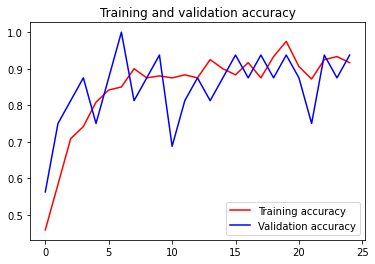

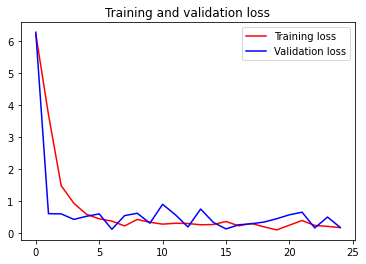

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
predict=model2.predict(testing_generator)
score = model2.evaluate(testing_generator, batch_size=1, verbose=1)

46/46 [==============================] - 14s 291ms/step - loss: 0.1621 - accuracy: 0.9617


## Test Upload

Saving unnamed.jpg to unnamed (1).jpg
{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
Bacterial leaf blight
Hasil Prediksi: Bacterial leaf blight


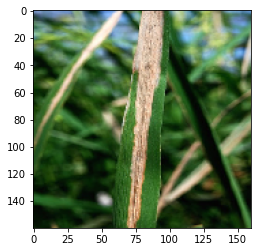

In [ ]:
uploaded = files.upload()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))

## Hasil sementara
model memiliki akurasi yang tidak cukup tinggi dan hasil upload cenderung memberi prediksi leaf smut 
(**Note(2):Bisa membedakan leaf smut dan BLB tapi belum brown spot)

##Export Inception

In [ ]:
UseInception_Saved_Model="exp_saved_model"

In [ ]:
tf.saved_model.save(model2,UseInception_Saved_Model)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [ ]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(UseInception_Saved_Model)
converter.optimizations = [optimization]

In [ ]:
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./model2.tflite')
tflite_model_file.write_bytes(tflite_model)

34376016